In [1]:
import sys, os
import random

sys.path.append("..")
from common_utils import DATA_HOME
import torch
import numpy as np

seed = 42

g = torch.Generator()
g.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

from lstm.sales_data import Sales_Dataset
from torch.utils.data.dataloader import DataLoader

In [2]:
SALE_HOME = os.path.join(DATA_HOME, "sales_data")

I, H, B = 528, 528, 4
TRANSFORMER_LAYER = 4
LSTM_LAYER = 2
HEAD = 12
SEQ_LEN = 116
INFER_DAYS = 16

sd = Sales_Dataset(SALE_HOME, seq_len=SEQ_LEN, device="cuda")
test_set, train_set = torch.utils.data.random_split(sd, [0.01, 0.99])
train_dl = DataLoader(train_set, shuffle=True, batch_size=B, generator=g)
test_dl = DataLoader(test_set, shuffle=True, batch_size=B, generator=g)
len(train_dl), len(test_dl)

(21010, 213)

In [3]:
print(len(train_dl), len(test_dl))
# print(sd.O.describe())
# print(sd.TS.describe())
# print(sd.S.describe())
print(sd[0][0].shape, sd[4][0].shape)
# print(sd[4][1].shape)
# print(sd[4][0], sd[4][1])

21010 213
torch.Size([116, 528]) torch.Size([116, 528])


In [4]:
from torch import optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
from predictor import Predictor

model = Predictor(I, H, LSTM_LAYER, TRANSFORMER_LAYER, HEAD).cuda()

In [5]:
MSE = torch.nn.MSELoss()


def RMSLE(yhat, y):
    return torch.sqrt(MSE(torch.log(yhat + 1), torch.log(y + 1)))

### PyTorch Model training

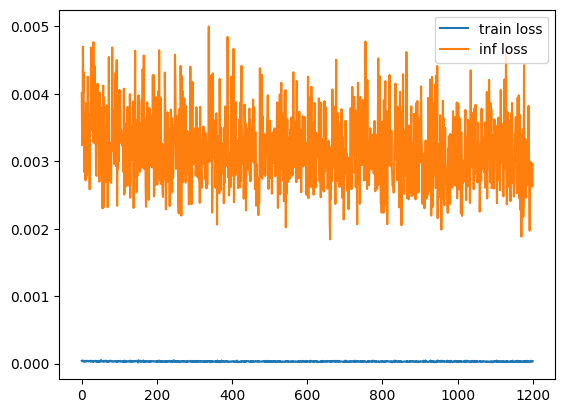

iteration: 1200 train loss: 3.4951567933537856e-05 inf loss: 0.002962799699093814


In [6]:
saved_iter = 0
resume_from = f"sales_model_{saved_iter}_{B}.pth"

if os.path.exists(resume_from):
    model.load_state_dict(torch.load(resume_from))
    print(f"{resume_from} model loaded")
else:
    saved_iter = 0

train_gen = enumerate(train_dl, saved_iter)
test_gen = enumerate(test_dl)

loss = RMSLE
adam = optim.Adam(model.parameters(), lr=0.001)
tr_losses, inf_losses = [], []


fig = plt.figure(figsize=(5, 5))
for tr_idx, (X1, X2, y0, y16) in train_gen:
    # Train
    tr_l, inf_l = 0, 0
    yhat1, yhat2 = model(X1, X2)
    yhat = Sales_Dataset.batched_ret_2_sales(y0, yhat1, yhat2)
    l = loss(yhat, y16)
    # update parameters
    adam.zero_grad()
    l.backward()
    adam.step()
    tr_l += l.item()

    # Validate
    try:
        inf_idx, (X1, X2, y0, y16) = next(test_gen)
    except StopIteration:  # re-initialize test set if exhausted
        test_gen = enumerate(test_dl)
        inf_idx, (X1, X2, y0, y16) = next(test_gen)

    yhat1, yhat2 = model(X1, X2)
    yhat = Sales_Dataset.batched_ret_2_sales(y0, yhat1, yhat2)
    l = loss(yhat, y16)
    inf_l += l.item()
    tr_losses.append(tr_l / len(train_dl))
    inf_losses.append(inf_l / len(test_dl))

    # Log and save
    if tr_idx and saved_iter != tr_idx and tr_idx % 100 == 0:
        clear_output(wait=True)
        plt.plot(
            range(saved_iter, saved_iter + len(tr_losses)),
            tr_losses,
            label="train loss",
        )
        plt.plot(
            range(saved_iter, saved_iter + len(inf_losses)),
            inf_losses,
            label="inf loss",
        )
        plt.xlim()
        plt.legend()
        plt.show()
        print(
            f"iteration: {tr_idx} train loss: {tr_l / len(train_dl)} inf loss: {inf_l / len(test_dl)}"
        )
    if tr_idx and tr_idx % 500 == 0:
        torch.save(model.state_dict(), f"sales_model_{tr_idx}_{B}.pth")

### display losses

In [ ]:
plt.plot(range(len(tr_losses)), tr_losses, label="train loss")
plt.plot(range(len(inf_losses)), inf_losses, label="test loss")
plt.legend()
plt.show()